# LDS作成

#### 観測と内部状態を比べてるので，図は合うわけがない．
#### 比較すべきは，予測した観測と真の観測である．

A
[[1.  0.1]
 [0.  1. ]]
C
[[1. 0.]]
Q
[[2.5e-05 5.0e-04]
 [5.0e-04 1.0e-02]]
R
[[1.]]
0
20
40
60
80
100
120
140
160
180
200
A
[[ 0.96675839  0.02688554]
 [ 1.53594172 -0.20937322]]
C
[[ 2.43437644 -0.72397912]]
Q
[[0.03523755 0.02467243]
 [0.02484625 0.73404744]]
R
[[0.42511804]]
pi_1
[[-0.20690268]
 [-0.60306611]]
V_1
[[0.03794886 0.07118952]
 [0.07126202 0.51176178]]


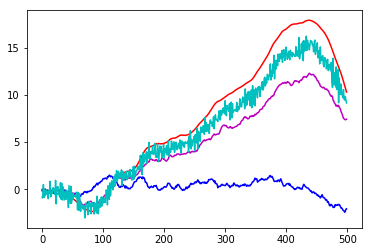

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def E_step(y, A, C, Q, R, pi_1, V_1):
    # num of observations
    T = len(y)

    # prediction
    x_p = {} # x_p[t-1] := x_t^{t-1}
    V_p = {} # V_p[t-1] := V_t^{t-1}
    K   = {} # K[t-1]   := K_t
    # filter
    x_f = {} # x_f[t-1] := x_t^t
    V_f = {} # V_f[t-1] := V_t^t
    # smoother
    J   = {} # J[t-1]   := J_{t}
    x_s = {} # x_s[t-1] := x_{t}^T
    V_s = {} # V_s[t-1] := V_{t}^T
    V_a = {} # V_a[t-1] := V_{t,t-1}^T
    # response
    x   = {} # x[t-1]   := {¥hat x}_t
    P   = {} # P[t-1]   := P_t
    P_a = {} # P_a[t-1] := P_{t,t-1}

    # kalman filter
    for t in range(T):
        if t == 0: # initialize
            x_p[t] = pi_1
            V_p[t] = V_1
        else:
            x_p[t] = A * x_f[t-1]
            V_p[t] = A * V_f[t-1] * A.T + Q
        K[t] = V_p[t] * C.T * np.linalg.pinv((C * V_p[t] * C.T + R))
        x_f[t] = x_p[t] + K[t] * (y[t] - C * x_p[t])
        V_f[t] = V_p[t] - K[t] * C * V_p[t]

    # kalman smoother
    x_s[T-1] = x_f[T-1]
    V_s[T-1] = V_f[T-1]
    for t in range(T-1, 0, -1):
        J[t-1] = V_f[t-1] * A.T * np.linalg.pinv(V_p[t])
        x_s[t-1] = x_f[t-1] + J[t-1] * (x_s[t] - A * x_f[t-1])
        V_s[t-1] = V_f[t-1] + J[t-1] * (V_s[t] - V_p[t]) * J[t-1].T

    I = np.mat(np.eye(*A.shape))
    V_a[T-1] = (I - K[T-1] * C) * A * V_f[T-2]
    for t in range(T-1, 1, -1):
        V_a[t-1] = V_f[t-1] * J[t-2].T + J[t-1] * (V_a[t] - A * V_f[t-1]) * J[t-2].T

    # set response
    for t in range(T):
        x[t] = x_s[t]
        P[t] = V_s[t] + x_s[t] * x_s[t].T
        if t == 0: continue
        P_a[t] = V_a[t] + x_s[t] * x_s[t-1].T

    return x, P, P_a

def M_step(y, x, P, P_a):
    # num of observations
    T = len(y)
    # Output matrix
    C = sum([y[t]*x[t].T for t in range(T)]) * np.linalg.pinv(sum([P[t] for t in range(T)]))
    # Output noise covariance
    R = sum([y[t]*y[t].T - C * x[t] * y[t].T for t in range(T)]) / T
    # State dynamics matrix
    A = sum([P_a[t] for t in range(1,T)]) * np.linalg.pinv(sum([ P[t-1] for t in range(1,T)]))
    # State noise covariance
    Q =  (sum([P[t] for t in range(1,T)]) - A * sum([P_a[t] for t in range(1,T)])) / (T - 1)
    #Q = sum( [ (P[t] - A * P_a[t]) for t in range(1,T) ] ) / (T-1)
    # Initail state mean
    pi_1 = x[1]
    # Initial state covariance
    V_1 = P[1] - x[1] * x[1].T

    return A, C, Q, R, pi_1, V_1

def main():
    #テストデータ生成
    dt = 0.1
    x = np.mat([[0.0],
                [0.0]])
    A = np.mat([[1.0,dt],
                [0.0,1.0]])
    C = np.mat([[1.0,0]])
    Q = np.mat([[dt**4/4,dt**3/2],
                [dt**3/2,dt**2]])
    R = np.mat([[1.0]])
    print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))
    
    #np.random.seed(seed=32)
    
    X = [] # 状態
    Y = [] # 観測
    K = 500 # サンプル数
    for i in range(K):
        x = A * x + np.mat(np.random.multivariate_normal((0,0),Q)).T
        y = C * x + np.mat(np.random.normal(0,1)).T
        X.append(x)
        Y.append(y)


    # 推定
    # 初期値をランダムに振る
    A = np.mat(np.random.rand(2,2))
    C = np.mat(np.random.rand(1,2))
    Q = np.mat(np.random.rand(2,2))
    Q = (Q + Q.T) / 2
    R = np.mat(np.random.rand(1,1))
    pi_1 = np.mat(np.random.rand(2,1))
    V_1 = np.mat(np.random.rand(2,2))
    V_1 = (V_1 + V_1.T) / 2

    N = 200 # EM回数
    e = E_step(Y, A, C, Q, R, pi_1, V_1)
    for i in range(N):
        if(i % 20 == 0):
            print (i)
        m = M_step(Y, *e)
        e = E_step(Y, *m)
    print(i+1)

    # 結果表示
    print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % m)
    x_hat, pi, pa = e
    # テストデータ
    X1 = []
    X2 = []
    # 推定結果
    X3 = []
    X4 = []
    for x in X:
        X1.append(x[0,0])
        X2.append(x[1,0])
    for i in x_hat:
        X3.append(x_hat[i][0,0])
        X4.append(x_hat[i][1,0])
    plt.plot(X1, 'r-')
    plt.plot(X2, 'b-')
    plt.plot(X3, 'm-')
    plt.plot(X4, 'c-')
    plt.show()

if __name__ == '__main__':
    main()

In [1]:
#テスト
import numpy as np

dt = 0.1
x = np.mat([[0.0],
            [0.0]])

A = np.mat([[1.0,dt],
            [0.0,1.0]])

C = np.mat([[1.0,0]])
Q = np.mat([[dt**4/4,dt**3/2],
            [dt**3/2,dt**2]])
R = np.mat([[1.0]])
    
print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))

A
[[1.  0.1]
 [0.  1. ]]
C
[[1. 0.]]
Q
[[2.5e-05 5.0e-04]
 [5.0e-04 1.0e-02]]
R
[[1.]]


## matをarrayにしたLDS

#### mat配列は，代入した変数配列の要素に変更が合った時，元のmat配列も変更される．
#### array配列は，代入した変数配列の要素に変更が合った時，元のarray配列は変更されない．
#### 以上二つの関係により，以下のように，パラメータがnanになった．
#### また，積のやり方も異なる．array同士は要素積(アダマール積)で，matrix同士は行列積である

matとmatrixの違い
URL: https://qiita.com/neka-nat@github/items/3d552611f6e0429782ed

matrixとarrayの違い
URL: https://hayataka2049.hatenablog.jp/entry/2018/01/22/203742

A
[[1.  0.1]
 [0.  1. ]]
C
[[1. 0.]]
Q
[[2.5e-05 5.0e-04]
 [5.0e-04 1.0e-02]]
R
[[1.]]
0
1
2
3
4


/mnt/nfs/takagi/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in multiply
/mnt/nfs/takagi/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
/mnt/nfs/takagi/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in multiply
/mnt/nfs/takagi/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in add
/mnt/nfs/takagi/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in multiply
/mnt/nfs/takagi/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in add
/mnt/nfs/takagi/.pyenv/versions/3.5.2/lib/python3.5/site-packages/numpy/linalg/linalg.py:1728: RuntimeWarning: invalid value encountered in greater
 

5
A
[[nan nan]
 [nan nan]]
C
[[nan nan]
 [nan nan]]
Q
[[nan nan]
 [nan nan]]
R
[[nan nan]
 [nan nan]]
pi_1
[[ 0.00000000e+000  9.11583889e+158]
 [-1.19543588e+137  0.00000000e+000]]
V_1
[[4.03998182e+44            nan]
 [0.00000000e+00 1.09742641e+43]]


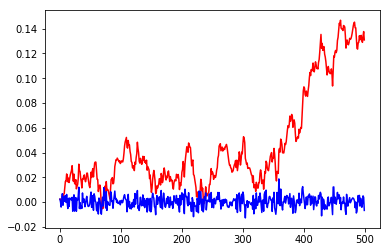

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def E_step(y, A, C, Q, R, pi_1, V_1):
    # num of observations
    T = len(y)

    # prediction
    x_p = {} # x_p[t-1] := x_t^{t-1}
    V_p = {} # V_p[t-1] := V_t^{t-1}
    K   = {} # K[t-1]   := K_t
    # filter
    x_f = {} # x_f[t-1] := x_t^t
    V_f = {} # V_f[t-1] := V_t^t
    # smoother
    J   = {} # J[t-1]   := J_{t}
    x_s = {} # x_s[t-1] := x_{t}^T
    V_s = {} # V_s[t-1] := V_{t}^T
    V_a = {} # V_a[t-1] := V_{t,t-1}^T
    # response
    x   = {} # x[t-1]   := {¥hat x}_t
    P   = {} # P[t-1]   := P_t
    P_a = {} # P_a[t-1] := P_{t,t-1}

    # kalman filter
    for t in range(T):
        if t == 0: # initialize
            x_p[t] = pi_1
            V_p[t] = V_1
        else:
            x_p[t] = A * x_f[t-1]
            V_p[t] = A * V_f[t-1] * A.T + Q
        K[t] = V_p[t] * C.T * np.linalg.pinv((C * V_p[t] * C.T + R))
        x_f[t] = x_p[t] + K[t] * (y[t] - C * x_p[t])
        V_f[t] = V_p[t] - K[t] * C * V_p[t]

    # kalman smoother
    x_s[T-1] = x_f[T-1]
    V_s[T-1] = V_f[T-1]
    for t in range(T-1, 0, -1):
        J[t-1] = V_f[t-1] * A.T * np.linalg.pinv(V_p[t])
        x_s[t-1] = x_f[t-1] + J[t-1] * (x_s[t] - A * x_f[t-1])
        V_s[t-1] = V_f[t-1] + J[t-1] * (V_s[t] - V_p[t]) * J[t-1].T

    I = np.eye(*A.shape)
    V_a[T-1] = (I - K[T-1] * C) * A * V_f[T-2]
    for t in range(T-1, 1, -1):
        V_a[t-1] = V_f[t-1] * J[t-2].T + J[t-1] * (V_a[t] - A * V_f[t-1]) * J[t-2].T

    # set response
    for t in range(T):
        x[t] = x_s[t]
        P[t] = V_s[t] + x_s[t] * x_s[t].T
        if t == 0: continue
        P_a[t] = V_a[t] + x_s[t] * x_s[t-1].T

    return x, P, P_a

def M_step(y, x, P, P_a):
    # num of observations
    T = len(y)
    # Output matrix
    C = sum([y[t]*x[t].T for t in range(T)]) * np.linalg.pinv(sum([P[t] for t in range(T)]))
    # Output noise covariance
    R = sum([y[t]*y[t].T - C * x[t] * y[t].T for t in range(T)]) / T
    # State dynamics matrix
    A = sum([P_a[t] for t in range(1,T)]) * np.linalg.pinv(sum([ P[t-1] for t in range(1,T)]))
    # State noise covariance
    Q =  (sum([P[t] for t in range(1,T)]) - A * sum([P_a[t] for t in range(1,T)])) / (T - 1)
    #Q = sum( [ (P[t] - A * P_a[t]) for t in range(1,T) ] ) / (T-1)
    # Initail state mean
    pi_1 = x[1]
    # Initial state covariance
    V_1 = P[1] - x[1] * x[1].T

    return A, C, Q, R, pi_1, V_1

def main():
    #テストデータ生成
    dt = 0.1
    x = np.array([[0.0],
                  [0.0]])
    A = np.array([[1.0,dt],
                  [0.0,1.0]])
    C = np.array([[1.0,0]])
    Q = np.array([[dt**4/4,dt**3/2],
                  [dt**3/2,dt**2]])
    R = np.array([[1.0]]) 
    print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))
    
    #np.random.seed(seed=32)
    
    X = [] # 状態
    Y = [] # 観測
    K = 500 # サンプル数
    for i in range(K):
        x = A * x + np.random.multivariate_normal((0,0),Q).T
        y = C * x + np.array(np.random.normal(0,1)).T
        X.append(x)
        Y.append(y)


    # 推定
    # 初期値をランダムに振る
    A = np.random.rand(2,2)
    C = np.random.rand(1,2)
    Q = np.random.rand(2,2)
    Q = (Q + Q.T) / 2
    R = np.random.rand(1,1)
    pi_1 = np.random.rand(2,1)
    V_1 = np.random.rand(2,2)
    V_1 = (V_1 + V_1.T) / 2

    N = 5 # EM回数
    e = E_step(Y, A, C, Q, R, pi_1, V_1)
    for i in range(N):
        #if(i % 20 == 0):
        print (i)
        m = M_step(Y, *e)
        e = E_step(Y, *m)
    print(i+1)

    # 結果表示
    print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % m)
    x_hat, pi, pa = e
    # テストデータ
    X1 = []
    X2 = []
    # 推定結果
    X3 = []
    X4 = []
    for x in X:
        X1.append(x[0,0])
        X2.append(x[1,0])
    for i in x_hat:
        X3.append(x_hat[i][0,0])
        X4.append(x_hat[i][1,0])
    plt.plot(X1, 'r-')
    plt.plot(X2, 'b-')
    plt.plot(X3, 'm-')
    plt.plot(X4, 'c-')
    plt.show()

if __name__ == '__main__':
    main()

## matをmatrixにしたLDS

A
[[1.  0.1]
 [0.  1. ]]
C
[[1. 0.]]
Q
[[2.5e-05 5.0e-04]
 [5.0e-04 1.0e-02]]
R
[[1.]]
0
20
40
60
80
100
A
[[ 1.56185764 -0.42666543]
 [ 2.20282351 -0.67988286]]
C
[[0.23576555 0.62643861]]
Q
[[0.15045509 0.42319969]
 [0.42302377 1.37393744]]
R
[[0.25353965]]
pi_1
[[ 0.07271265]
 [-0.27896043]]
V_1
[[0.06378743 0.11460836]
 [0.11456204 0.37793686]]


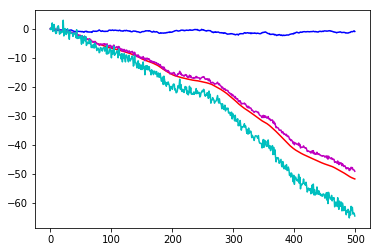

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def E_step(y, A, C, Q, R, pi_1, V_1):
    # num of observations
    T = len(y)

    # prediction
    x_p = {} # x_p[t-1] := x_t^{t-1}
    V_p = {} # V_p[t-1] := V_t^{t-1}
    K   = {} # K[t-1]   := K_t
    # filter
    x_f = {} # x_f[t-1] := x_t^t
    V_f = {} # V_f[t-1] := V_t^t
    # smoother
    J   = {} # J[t-1]   := J_{t}
    x_s = {} # x_s[t-1] := x_{t}^T
    V_s = {} # V_s[t-1] := V_{t}^T
    V_a = {} # V_a[t-1] := V_{t,t-1}^T
    # response
    x   = {} # x[t-1]   := {¥hat x}_t
    P   = {} # P[t-1]   := P_t
    P_a = {} # P_a[t-1] := P_{t,t-1}

    # kalman filter
    for t in range(T):
        if t == 0: # initialize
            x_p[t] = pi_1
            V_p[t] = V_1
        else:
            x_p[t] = A * x_f[t-1]
            V_p[t] = A * V_f[t-1] * A.T + Q
        K[t] = V_p[t] * C.T * np.linalg.pinv((C * V_p[t] * C.T + R))
        x_f[t] = x_p[t] + K[t] * (y[t] - C * x_p[t])
        V_f[t] = V_p[t] - K[t] * C * V_p[t]

    # kalman smoother
    x_s[T-1] = x_f[T-1]
    V_s[T-1] = V_f[T-1]
    for t in range(T-1, 0, -1):
        J[t-1] = V_f[t-1] * A.T * np.linalg.pinv(V_p[t])
        x_s[t-1] = x_f[t-1] + J[t-1] * (x_s[t] - A * x_f[t-1])
        V_s[t-1] = V_f[t-1] + J[t-1] * (V_s[t] - V_p[t]) * J[t-1].T

    I = np.matrix(np.eye(*A.shape))
    V_a[T-1] = (I - K[T-1] * C) * A * V_f[T-2]
    for t in range(T-1, 1, -1):
        V_a[t-1] = V_f[t-1] * J[t-2].T + J[t-1] * (V_a[t] - A * V_f[t-1]) * J[t-2].T

    # set response
    for t in range(T):
        x[t] = x_s[t]
        P[t] = V_s[t] + x_s[t] * x_s[t].T
        if t == 0: continue
        P_a[t] = V_a[t] + x_s[t] * x_s[t-1].T

    return x, P, P_a

def M_step(y, x, P, P_a):
    # num of observations
    T = len(y)
    # Output matrix
    C = sum([y[t]*x[t].T for t in range(T)]) * np.linalg.pinv(sum([P[t] for t in range(T)]))
    # Output noise covariance
    R = sum([y[t]*y[t].T - C * x[t] * y[t].T for t in range(T)]) / T
    # State dynamics matrix
    A = sum([P_a[t] for t in range(1,T)]) * np.linalg.pinv(sum([ P[t-1] for t in range(1,T)]))
    # State noise covariance
    Q =  (sum([P[t] for t in range(1,T)]) - A * sum([P_a[t] for t in range(1,T)])) / (T - 1)
    #Q = sum( [ (P[t] - A * P_a[t]) for t in range(1,T) ] ) / (T-1)
    # Initail state mean
    pi_1 = x[1]
    # Initial state covariance
    V_1 = P[1] - x[1] * x[1].T

    return A, C, Q, R, pi_1, V_1

def main():
    #テストデータ生成
    dt = 0.1
    x = np.matrix([[0.0],
                [0.0]])
    A = np.matrix([[1.0,dt],
                [0.0,1.0]])
    C = np.matrix([[1.0,0]])
    Q = np.matrix([[dt**4/4,dt**3/2],
                [dt**3/2,dt**2]])
    R = np.matrix([[1.0]])
    print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))
    
    #np.random.seed(seed=32)
    
    X = [] # 状態
    Y = [] # 観測
    K = 500 # サンプル数
    for i in range(K):
        x = A * x + np.matrix(np.random.multivariate_normal((0,0),Q)).T
        y = C * x + np.matrix(np.random.normal(0,1)).T
        X.append(x)
        Y.append(y)


    # 推定
    # 初期値をランダムに振る
    A = np.matrix(np.random.rand(2,2))
    C = np.matrix(np.random.rand(1,2))
    Q = np.matrix(np.random.rand(2,2))
    Q = (Q + Q.T) / 2
    R = np.matrix(np.random.rand(1,1))
    pi_1 = np.matrix(np.random.rand(2,1))
    V_1 = np.matrix(np.random.rand(2,2))
    V_1 = (V_1 + V_1.T) / 2

    N = 100 # EM回数
    e = E_step(Y, A, C, Q, R, pi_1, V_1)
    for i in range(N):
        if(i % 20 == 0):
            print (i)
        m = M_step(Y, *e)
        e = E_step(Y, *m)
    print(i+1)

    # 結果表示
    print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % m)
    x_hat, pi, pa = e
    # テストデータ
    X1 = []
    X2 = []
    # 推定結果
    X3 = []
    X4 = []
    for x in X:
        X1.append(x[0,0])
        X2.append(x[1,0])
    for i in x_hat:
        X3.append(x_hat[i][0,0])
        X4.append(x_hat[i][1,0])
    plt.plot(X1, 'r-')
    plt.plot(X2, 'b-')
    plt.plot(X3, 'm-')
    plt.plot(X4, 'c-')
    plt.show()

if __name__ == '__main__':
    main()

#### 多変量ガウスと対数尤度関数の作成実験
#### 初期値の行列対角に変更(多変量ガウスのため，正定値行列にする必要がある．)

In [14]:
import numpy as np
from scipy.stats import multivariate_normal

#np.random.seed(seed=32)

#テストデータ生成
dt = 0.1
x = np.mat([[0.0],
            [0.0]])
A = np.mat([[1.0,dt],
            [0.0,1.0]])
C = np.mat([[1.0,0]])
Q = np.mat([[dt**4/4,dt**3/2],
            [dt**3/2,dt**2]])
R = np.mat([[1.0]])
print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))

"""a = np.mat(np.random.rand(3,3))
A = np.mat([[a[0,0],0.0],
            [0.0,a[0,1]]])
C = np.mat(np.random.rand(1,2))
Q = np.mat([[a[2,0],0.0],
            [0.0,a[2,1]]])"""

um = np.mat(np.eye(2))

A_u = np.mat(np.random.rand(2,2))
A = np.multiply(A_u, um)

C = np.mat(np.random.rand(1,2))
Q_u = np.mat(np.random.rand(2,2))
Q = np.multiply(Q_u, um)
#Q = (Q + Q.T) / 2
R = np.mat(np.random.rand(1,1))
pi_1 = np.mat(np.random.rand(2,1))
V_1 = np.mat(np.random.rand(2,2))
V_1 = (V_1 + V_1.T) / 2

print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % (A, C, Q, R, pi_1, V_1))

X = [] # 状態
Y = [] # 観測
K = 500 # サンプル数
for i in range(K):
    x = A * x + np.mat(np.random.multivariate_normal((0,0),Q)).T
    y = C * x + np.mat(np.random.normal(0,1)).T
    X.append(x)
    Y.append(y)

print()
print("X_1\n%s\nY_1\n%s" %(X[0], Y[0]))

# 多変量ガウス分布
print("A_X\n", A*X[0])

mu = A*X[0]
cova = Q

print("mu\n%s\n" %mu)
print("covariance\n%s\n" %cova)
print("固有値\n",np.linalg.eig(cova))

a = np.sqrt(np.linalg.det(cova)*(2*np.pi)**cova.ndim)
b = np.linalg.det((X[1]-mu).T * np.linalg.pinv(cova) * (X[1]-mu))
c = np.exp(b)/a

#対数化
ln_c = b - (1/2)*(np.log(np.linalg.det(cova)) + cova.ndim*np.log(2*np.pi))

print()
print("多変量ガウス\n%s\n" %c)
print("対数ガウス\n%s\n" %ln_c)

A
[[1.  0.1]
 [0.  1. ]]
C
[[1. 0.]]
Q
[[2.5e-05 5.0e-04]
 [5.0e-04 1.0e-02]]
R
[[1.]]
A
[[0.62812261 0.        ]
 [0.         0.38542595]]
C
[[0.30020791 0.41028006]]
Q
[[0.21655739 0.        ]
 [0.         0.59325886]]
R
[[0.78321637]]
pi_1
[[0.38593552]
 [0.34014283]]
V_1
[[0.83221577 0.25877682]
 [0.25877682 0.60606863]]

X_1
[[0.03453961]
 [0.82044614]]
Y_1
[[-0.17734632]]
A_X
 [[0.02169511]
 [0.31622123]]
mu
[[0.02169511]
 [0.31622123]]

covariance
[[0.21655739 0.        ]
 [0.         0.59325886]]

固有値
 (array([0.21655739, 0.59325886]), matrix([[1., 0.],
        [0., 1.]]))

多変量ガウス
0.8700462996513714

対数ガウス
-0.13920885075945244



#### 全ての時刻の多変量ガウスの対数尤度の和を求める

In [53]:
import numpy as np
from scipy.stats import multivariate_normal

#np.random.seed(seed=32)

#テストデータ生成
dt = 0.1
x = np.mat([[0.0],
            [0.0]])
A = np.mat([[1.0,dt],
            [0.0,1.0]])
C = np.mat([[1.0,0]])
Q = np.mat([[dt**4/4,dt**3/2],
            [dt**3/2,dt**2]])
R = np.mat([[1.0]])
#print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))

um = np.mat(np.eye(2))

A_u = np.mat(np.random.rand(2,2))
A = np.multiply(A_u, um)
C = np.mat(np.random.rand(1,2))
Q_u = np.mat(np.random.rand(2,2))
Q = np.multiply(Q_u, um)
R = np.mat(np.random.rand(1,1))

pi_1 = np.mat(np.random.rand(2,1))
V_1_u = np.mat(np.random.rand(2,2))
V_1 = np.multiply(V_1_u, um)

#print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % (A, C, Q, R, pi_1, V_1))

X = [] # 状態
Y = [] # 観測
K = 500 # サンプル数
for i in range(K):
    x = A * x + np.mat(np.random.multivariate_normal((0,0),Q)).T
    y = C * x + np.mat(np.random.normal(0,1)).T
    X.append(x)
    Y.append(y)

print("X_1\n%s\nY_1\n%s\n" %(X[0], Y[0]))

#全時刻の対数尤度の和
ln_like_sums = 0

for i in range(K):
    #1時刻目(forループの0番目)
    if i == 0:
        mu_sta = pi_1
        b_sta = np.linalg.det((X[i]-mu_sta).T * np.linalg.pinv(V_1) * (X[i]-mu_sta))
        ln_sta = b_sta - (1/2)*(np.log(np.linalg.det(V_1)) + X[i].ndim*np.log(2*np.pi))
        
        mu_out = C*X[i]
        b_out = np.linalg.det((Y[i]-mu_out).T * np.linalg.pinv(R) * (Y[i]-mu_out))
        ln_out = b_out - (1/2)*(np.log(np.linalg.det(R)) + Y[i].ndim*np.log(2*np.pi))
        
    #2時刻目以降(forループの1番目以降)
    elif i > 0:
        mu_sta = A*X[i-1]
        b_sta = np.linalg.det((X[i]-mu_sta).T * np.linalg.pinv(Q) * (X[i]-mu_sta))
        ln_sta = b_sta - (1/2)*(np.log(np.linalg.det(Q)) + X[i].ndim*np.log(2*np.pi))
        
        mu_out = C*X[i]
        b_out = np.linalg.det((Y[i]-mu_out).T * np.linalg.pinv(R) * (Y[i]-mu_out))
        ln_out = b_out - (1/2)*(np.log(np.linalg.det(R)) + Y[i].ndim*np.log(2*np.pi))
    
    ln_like_sums = ln_like_sums + ln_sta + ln_out

print("全時刻の対数尤度\n%s\n" %ln_like_sums)

X_1
[[ 0.70328335]
 [-0.08042612]]
Y_1
[[0.29917442]]

全時刻の対数尤度
519.5774090223184



## 収束条件を改良したLDS

A
[[0.1 0. ]
 [0.  1. ]]
C
[[1. 0.]]
Q
[[2.5e-05 0.0e+00]
 [0.0e+00 1.0e-02]]
R
[[1.]]
0
差異
4088.2471044643967

5
差異
4266.050472446939

10
差異
4374.272853435643

15
差異
4434.566015515928

20
差異
4464.128150498334

25
差異
4474.199373057185

30
差異
4472.042532784544

35
差異
4462.290482966695

40
差異
4447.86300807161

45
差異
4430.58585847303

50
差異
4411.596388274309

55
差異
4391.602513172489

60
差異
4371.0452556427335

65
差異
4350.199841469468

70
差異
4329.238337163813

75
差異
4308.268442256318

80
差異
4287.357553755923

85
差異
4266.54773757793

90
差異
4245.865076415241

95
差異
4225.325529700727

100
A
[[ 0.04212328 -0.20308162]
 [-0.08169535  0.28653518]]
C
[[0.55791751 0.64262723]]
Q
[[ 0.58269099 -0.0171672 ]
 [-0.01703703  0.25446408]]
R
[[0.82208061]]
pi_1
[[0.28856437]
 [0.17148779]]
V_1
[[ 0.50785139 -0.08115422]
 [-0.08105703  0.25832795]]


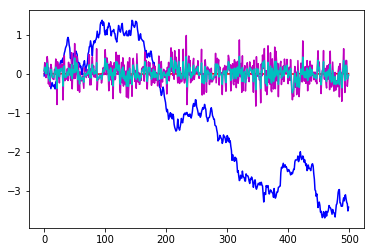

In [13]:
'''
Parameter Estimation for Linear Dynamical Systems
x[t] = A*x[t-1] + w[t]
y[t] = C*x[t] + v[t]
w[t] ~ N(0,Q)
v[t] ~ N(0,R)
'''

import numpy as np
import matplotlib.pyplot as plt

def E_step(y, A, C, Q, R, pi_1, V_1):
    # num of observations
    T = len(y)

    # prediction
    x_p = {} # x_p[t-1] := x_t^{t-1}
    V_p = {} # V_p[t-1] := V_t^{t-1}
    K   = {} # K[t-1]   := K_t
    # filter
    x_f = {} # x_f[t-1] := x_t^t
    V_f = {} # V_f[t-1] := V_t^t
    # smoother
    J   = {} # J[t-1]   := J_{t}
    x_s = {} # x_s[t-1] := x_{t}^T
    V_s = {} # V_s[t-1] := V_{t}^T
    V_a = {} # V_a[t-1] := V_{t,t-1}^T
    # response
    x   = {} # x[t-1]   := {¥hat x}_t
    P   = {} # P[t-1]   := P_t
    P_a = {} # P_a[t-1] := P_{t,t-1}

    # kalman filter
    for t in range(T):
        if t == 0: # initialize
            x_p[t] = pi_1
            V_p[t] = V_1
        else:
            x_p[t] = A * x_f[t-1]
            V_p[t] = A * V_f[t-1] * A.T + Q
        K[t] = V_p[t] * C.T * np.linalg.pinv((C * V_p[t] * C.T + R))
        x_f[t] = x_p[t] + K[t] * (y[t] - C * x_p[t])
        V_f[t] = V_p[t] - K[t] * C * V_p[t]

    # kalman smoother
    x_s[T-1] = x_f[T-1]
    V_s[T-1] = V_f[T-1]
    for t in range(T-1, 0, -1):
        J[t-1] = V_f[t-1] * A.T * np.linalg.pinv(V_p[t])
        x_s[t-1] = x_f[t-1] + J[t-1] * (x_s[t] - A * x_f[t-1])
        V_s[t-1] = V_f[t-1] + J[t-1] * (V_s[t] - V_p[t]) * J[t-1].T

    I = np.mat(np.eye(*A.shape))
    V_a[T-1] = (I - K[T-1] * C) * A * V_f[T-2]
    for t in range(T-1, 1, -1):
        V_a[t-1] = V_f[t-1] * J[t-2].T + J[t-1] * (V_a[t] - A * V_f[t-1]) * J[t-2].T

    # set response
    for t in range(T):
        x[t] = x_s[t]
        P[t] = V_s[t] + x_s[t] * x_s[t].T
        if t == 0: continue
        P_a[t] = V_a[t] + x_s[t] * x_s[t-1].T

    return x, P, P_a

def M_step(y, x, P, P_a):
    # num of observations
    T = len(y)
    # Output matrix
    C = sum([y[t]*x[t].T for t in range(T)]) * np.linalg.pinv(sum([P[t] for t in range(T)]))
    # Output noise covariance
    R = sum([y[t]*y[t].T - C * x[t] * y[t].T for t in range(T)]) / T
    # State dynamics matrix
    A = sum([P_a[t] for t in range(1,T)]) * np.linalg.pinv(sum([ P[t-1] for t in range(1,T)]))
    # State noise covariance
    Q =  (sum([P[t] for t in range(1,T)]) - A * sum([P_a[t] for t in range(1,T)])) / (T - 1)
    #Q = sum( [ (P[t] - A * P_a[t]) for t in range(1,T) ] ) / (T-1)
    # Initail state mean
    pi_1 = x[1]
    # Initial state covariance
    V_1 = P[1] - x[1] * x[1].T

    return A, C, Q, R, pi_1, V_1

def main():
    #テストデータ生成
    dt = 0.1
    x = np.mat([[0.0],
                [0.0]])
    A = np.mat([[dt,0.0],
                [0.0,1.0]])
    C = np.mat([[1.0,0.0]])
    Q = np.mat([[dt**4/4,0],
                [0,dt**2]])
    R = np.mat([[1.0]])
    print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))
    
    #np.random.seed(seed=32)
    
    X = [] # 状態
    Y = [] # 観測
    K = 500 # サンプル数
    for i in range(K):
        x = A * x + np.mat(np.random.multivariate_normal((0,0),Q)).T
        y = C * x + np.mat(np.random.normal(0,1)).T
        X.append(x)
        Y.append(y)

    # 推定
    # 初期値をランダムに振る    
    um = np.mat(np.eye(2))

    A_u = np.mat(np.random.rand(2,2))
    A = np.multiply(A_u, um)
    C = np.mat(np.random.rand(1,2))
    Q_u = np.mat(np.random.rand(2,2))
    Q = np.multiply(Q_u, um)
    R = np.mat(np.random.rand(1,1))

    pi_1 = np.mat(np.random.rand(2,1))
    V_1_u = np.mat(np.random.rand(2,2))
    V_1 = np.multiply(V_1_u, um)
    
    old = 0
    ln_like_sums = 0
    eta = 0.01 #収束判定のための閾値
    N = 100 # EM回数
    
    e = E_step(Y, A, C, Q, R, pi_1, V_1)
    for i in range(N):
        m = M_step(Y, *e)
        e = E_step(Y, *m)
        
        A, C, Q, R, pi_1, V_1 = m
        X_hat, pi, pa = e
        
        for t in range(K):
            #1時刻目(forループの0番目)
            if(t == 0):
                mu_sta = pi_1
                b_sta = np.linalg.det((X[t]-mu_sta).T * np.linalg.pinv(V_1) * (X[t]-mu_sta))
                ln_sta = b_sta - (1/2)*(np.log(np.linalg.det(V_1)) + X[t].ndim*np.log(2*np.pi))
        
                mu_out = C*X[t]
                b_out = np.linalg.det((Y[t]-mu_out).T * np.linalg.pinv(R) * (Y[t]-mu_out))
                ln_out = b_out - (1/2)*(np.log(np.linalg.det(R)) + Y[t].ndim*np.log(2*np.pi))
        
            #2時刻目以降(forループの1番目以降)
            elif(t > 0):
                mu_sta = A*X[t-1]
                b_sta = np.linalg.det((X[t]-mu_sta).T * np.linalg.pinv(Q) * (X[t]-mu_sta))
                ln_sta = b_sta - (1/2)*(np.log(np.linalg.det(Q)) + X[t].ndim*np.log(2*np.pi))
        
                mu_out = C*X[t]
                b_out = np.linalg.det((Y[t]-mu_out).T * np.linalg.pinv(R) * (Y[t]-mu_out))
                ln_out = b_out - (1/2)*(np.log(np.linalg.det(R)) + Y[t].ndim*np.log(2*np.pi))
    
            ln_like_sums = ln_like_sums + ln_sta + ln_out
        
        if(np.abs(old - ln_like_sums) < eta):
            print(i)
            diff = np.abs(old - ln_like_sums)
            print("差異\n%s\n" %diff)
            break
        
        if(i % 5 == 0):
            diff = np.abs(old - ln_like_sums)
            print (i)
            print("差異\n%s\n" %diff)
        
        old = ln_like_sums
        
    print(N)
    
    # 結果表示
    print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % m)
    x_hat, pi, pa = e
    # テストデータ
    X1 = []
    X2 = []
    # 推定結果
    X3 = []
    X4 = []
    for x in X:
        X1.append(x[0,0])
        X2.append(x[1,0])
    for i in x_hat:
        X3.append(x_hat[i][0,0])
        X4.append(x_hat[i][1,0])
    plt.plot(X1, 'r-')
    plt.plot(X2, 'b-')
    plt.plot(X3, 'm-')
    plt.plot(X4, 'c-')
    plt.show()

if __name__ == '__main__':
    main()

## 出力変数と潜在変数の次元を自由に変更できるようにした改良LDS

0
sec/5epoch: 22.74292016029358

5
sec/5epoch: 51.547592639923096

10
sec/5epoch: 51.68893003463745

15
sec/5epoch: 51.68295383453369

20
sec/5epoch: 51.55196690559387

25
sec/5epoch: 51.03593039512634

30
実行時間
320.9846374988556
A
[[ 0.46426388 -0.28894404 -0.04269863 ... -0.04762023 -0.20710491
  -0.03554425]
 [ 0.10712525  0.78070167  0.47937749 ...  0.28733708  0.25128073
   0.3965135 ]
 [ 0.04379616  0.1912864   0.81774201 ...  0.28277993  0.20160396
   0.17392422]
 ...
 [ 0.00896024 -0.23227317 -0.05508845 ...  0.56246258  0.60172283
  -0.05996046]
 [-0.09787797 -0.01386957 -0.14652474 ... -0.34458836  0.03652002
  -0.09644146]
 [-0.34976474 -0.01406926  0.00200064 ... -0.23103205 -0.39885313
   0.28756094]]
C
[[ 0.26830525  0.42506164  0.14839254 ...  0.36780722  0.48304258
   0.47244919]
 [ 0.34285741  0.34078315  0.31172964 ...  0.4109529   0.25698322
   0.01773896]
 [ 0.87747659  0.16373423  0.88121131 ...  0.6745983   0.69855341
   0.70445144]
 ...
 [ 0.68546872  0.16061816  

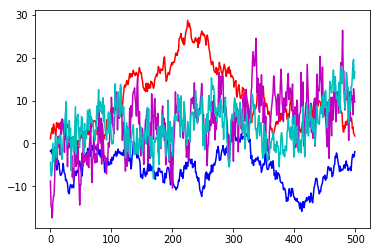

In [28]:
'''
Parameter Estimation for Linear Dynamical Systems
x[t] = A*x[t-1] + w[t]
y[t] = C*x[t] + v[t]
w[t] ~ N(0,Q)
v[t] ~ N(0,R)
'''

import numpy as np
import matplotlib.pyplot as plt
import time

def E_step(y, A, C, Q, R, pi_1, V_1):
    # num of observations
    T = len(y)

    # prediction
    x_p = {} # x_p[t-1] := x_t^{t-1}
    V_p = {} # V_p[t-1] := V_t^{t-1}
    K   = {} # K[t-1]   := K_t
    # filter
    x_f = {} # x_f[t-1] := x_t^t
    V_f = {} # V_f[t-1] := V_t^t
    # smoother
    J   = {} # J[t-1]   := J_{t}
    x_s = {} # x_s[t-1] := x_{t}^T
    V_s = {} # V_s[t-1] := V_{t}^T
    V_a = {} # V_a[t-1] := V_{t,t-1}^T
    # response
    x   = {} # x[t-1]   := {¥hat x}_t
    P   = {} # P[t-1]   := P_t
    P_a = {} # P_a[t-1] := P_{t,t-1}

    # kalman filter
    for t in range(T):
        if t == 0: # initialize
            x_p[t] = pi_1
            V_p[t] = V_1
        else:
            x_p[t] = A * x_f[t-1]
            V_p[t] = A * V_f[t-1] * A.T + Q
        K[t] = V_p[t] * C.T * np.linalg.pinv((C * V_p[t] * C.T + R))
        x_f[t] = x_p[t] + K[t] * (y[t] - C * x_p[t])
        V_f[t] = V_p[t] - K[t] * C * V_p[t]

    # kalman smoother
    x_s[T-1] = x_f[T-1]
    V_s[T-1] = V_f[T-1]
    for t in range(T-1, 0, -1):
        J[t-1] = V_f[t-1] * A.T * np.linalg.pinv(V_p[t])
        x_s[t-1] = x_f[t-1] + J[t-1] * (x_s[t] - A * x_f[t-1])
        V_s[t-1] = V_f[t-1] + J[t-1] * (V_s[t] - V_p[t]) * J[t-1].T

    I = np.mat(np.eye(*A.shape))
    V_a[T-1] = (I - K[T-1] * C) * A * V_f[T-2]
    for t in range(T-1, 1, -1):
        V_a[t-1] = V_f[t-1] * J[t-2].T + J[t-1] * (V_a[t] - A * V_f[t-1]) * J[t-2].T

    # set response
    for t in range(T):
        x[t] = x_s[t]
        P[t] = V_s[t] + x_s[t] * x_s[t].T
        if t == 0: continue
        P_a[t] = V_a[t] + x_s[t] * x_s[t-1].T

    return x, P, P_a

def M_step(y, x, P, P_a):
    # num of observations
    T = len(y)
    # Output matrix
    C = sum([y[t]*x[t].T for t in range(T)]) * np.linalg.pinv(sum([P[t] for t in range(T)]))
    # Output noise covariance
    R = sum([y[t]*y[t].T - C * x[t] * y[t].T for t in range(T)]) / T
    # State dynamics matrix
    A = sum([P_a[t] for t in range(1,T)]) * np.linalg.pinv(sum([ P[t-1] for t in range(1,T)]))
    # State noise covariance
    Q =  (sum([P[t] for t in range(1,T)]) - A * sum([P_a[t] for t in range(1,T)])) / (T - 1)
    #Q = sum( [ (P[t] - A * P_a[t]) for t in range(1,T) ] ) / (T-1)
    # Initail state mean
    pi_1 = x[1]
    # Initial state covariance
    V_1 = P[1] - x[1] * x[1].T

    return A, C, Q, R, pi_1, V_1

def main():
    
    start = time.time()
    
    #テストデータ生成
    """dt = 0.1
    x = np.mat([[0.0],
                [0.0]])
    A = np.mat([[dt,0.0],
                [0.0,1.0]])
    C = np.mat([[1.0,0.0]])
    Q = np.mat([[dt**4/4,0],
                [0,dt**2]])
    R = np.mat([[1.0]])"""
    
    #テストデータ生成(次元を自由に変更可能)
    dms = 100
    dmo = 100
    dt = 0.1
    x =np.mat(np.zeros([dms, 1]))
    A = np.mat(np.eye(dms, dms))
    C = np.mat(np.eye(dmo, dms))
    Q = np.mat(np.eye(dms, dms))
    R = np.mat(np.eye(dmo, dmo))
    
    #print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))
    
    X = [] # 状態
    Y = [] # 観測
    K = 500 # サンプル数
    for i in range(K):
        #x = A * x + np.mat(np.random.multivariate_normal((0,0),Q)).T
        #x = A * x + np.mat(np.random.multivariate_normal(np.zeros(dms).tolist(),Q)).T
        #y = C * x + np.mat(np.random.normal(0,1)).T
        #y = C * x + np.mat(np.random.normal(np.zeros(dmo).tolist(),R)).T 
        x = A * x + np.mat(np.random.multivariate_normal(np.zeros(dms).tolist(),Q)).T
        y = C * x + np.mat(np.random.multivariate_normal(np.zeros(dmo).tolist(),R)).T
        X.append(x)
        Y.append(y)
    
    #print("X\n%s\nY\n%s\n" % (X[0].shape, Y[0].shape))
    
    # 推定
    # パラメータの初期値をランダムに振る    
    ums = np.mat(np.eye(dms))
    umo = np.mat(np.eye(dmo))
    
    A_u = np.mat(np.random.rand(dms,dms))
    A = np.multiply(A_u, ums)
    C = np.mat(np.random.rand(dmo,dms))
    
    Q_u = np.mat(np.random.rand(dms,dms))
    Q = np.multiply(Q_u, ums)
    R_u = np.mat(np.random.rand(dmo,dmo))
    R = np.multiply(R_u, umo)

    pi_1 = np.mat(np.random.rand(dms,1))
    V_1_u = np.mat(np.random.rand(dms,dms))
    V_1 = np.multiply(V_1_u, ums)
    
    #print("pi_1\n%s\nV_1\n%s" % (pi_1, V_1))
    
    eta = 0.01 #収束判定のための閾値
    N = 30 # EM回数
    tm = start #start時間をtmに代入
    
    e = E_step(Y, A, C, Q, R, pi_1, V_1)
    for i in range(N):
        m = M_step(Y, *e)
        e = E_step(Y, *m)
        
        A, C, Q, R, pi_1, V_1 = m
        X_hat, pi, pa = e
        
        if(i % 5 == 0):
            print (i)
            print("sec/5epoch: %s\n" %(time.time()-tm))
            tm = time.time()
        
    print(N)
    
    # 結果表示
    print("実行時間\n%s" %(time.time()-start))
    print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % m)
    x_hat, pi, pa = e
    # テストデータ
    X1 = []
    X2 = []
    # 推定結果
    X3 = []
    X4 = []
    for x in X:
        X1.append(x[0,0])
        X2.append(x[1,0])
    for i in x_hat:
        X3.append(x_hat[i][0,0])
        X4.append(x_hat[i][1,0])
    plt.plot(X1, 'r-')
    plt.plot(X2, 'b-')
    plt.plot(X3, 'm-')
    plt.plot(X4, 'c-')
    plt.show()

if __name__ == '__main__':
    main()

## 出力変数と潜在変数の次元を自由に変更できるようにして，収束条件を変更した改良LDS

In [ ]:
'''
Parameter Estimation for Linear Dynamical Systems
x[t] = A*x[t-1] + w[t]
y[t] = C*x[t] + v[t]
w[t] ~ N(0,Q)
v[t] ~ N(0,R)
'''

import numpy as np
import matplotlib.pyplot as plt
import time

def E_step(y, A, C, Q, R, pi_1, V_1):
    # num of observations
    T = len(y)

    # prediction
    x_p = {} # x_p[t-1] := x_t^{t-1}
    V_p = {} # V_p[t-1] := V_t^{t-1}
    K   = {} # K[t-1]   := K_t
    # filter
    x_f = {} # x_f[t-1] := x_t^t
    V_f = {} # V_f[t-1] := V_t^t
    # smoother
    J   = {} # J[t-1]   := J_{t}
    x_s = {} # x_s[t-1] := x_{t}^T
    V_s = {} # V_s[t-1] := V_{t}^T
    V_a = {} # V_a[t-1] := V_{t,t-1}^T
    # response
    x   = {} # x[t-1]   := {¥hat x}_t
    P   = {} # P[t-1]   := P_t
    P_a = {} # P_a[t-1] := P_{t,t-1}

    # kalman filter
    for t in range(T):
        if t == 0: # initialize
            x_p[t] = pi_1
            V_p[t] = V_1
        else:
            x_p[t] = A * x_f[t-1]
            V_p[t] = A * V_f[t-1] * A.T + Q
        K[t] = V_p[t] * C.T * np.linalg.pinv((C * V_p[t] * C.T + R))
        x_f[t] = x_p[t] + K[t] * (y[t] - C * x_p[t])
        V_f[t] = V_p[t] - K[t] * C * V_p[t]

    # kalman smoother
    x_s[T-1] = x_f[T-1]
    V_s[T-1] = V_f[T-1]
    for t in range(T-1, 0, -1):
        J[t-1] = V_f[t-1] * A.T * np.linalg.pinv(V_p[t])
        x_s[t-1] = x_f[t-1] + J[t-1] * (x_s[t] - A * x_f[t-1])
        V_s[t-1] = V_f[t-1] + J[t-1] * (V_s[t] - V_p[t]) * J[t-1].T

    I = np.mat(np.eye(*A.shape))
    V_a[T-1] = (I - K[T-1] * C) * A * V_f[T-2]
    for t in range(T-1, 1, -1):
        V_a[t-1] = V_f[t-1] * J[t-2].T + J[t-1] * (V_a[t] - A * V_f[t-1]) * J[t-2].T

    # set response
    for t in range(T):
        x[t] = x_s[t]
        P[t] = V_s[t] + x_s[t] * x_s[t].T
        if t == 0: continue
        P_a[t] = V_a[t] + x_s[t] * x_s[t-1].T

    return x, P, P_a

def M_step(y, x, P, P_a):
    # num of observations
    T = len(y)
    # Output matrix
    C = sum([y[t]*x[t].T for t in range(T)]) * np.linalg.pinv(sum([P[t] for t in range(T)]))
    # Output noise covariance
    R = sum([y[t]*y[t].T - C * x[t] * y[t].T for t in range(T)]) / T
    # State dynamics matrix
    A = sum([P_a[t] for t in range(1,T)]) * np.linalg.pinv(sum([ P[t-1] for t in range(1,T)]))
    # State noise covariance
    Q =  (sum([P[t] for t in range(1,T)]) - A * sum([P_a[t] for t in range(1,T)])) / (T - 1)
    #Q = sum( [ (P[t] - A * P_a[t]) for t in range(1,T) ] ) / (T-1)
    # Initail state mean
    pi_1 = x[1]
    # Initial state covariance
    V_1 = P[1] - x[1] * x[1].T

    return A, C, Q, R, pi_1, V_1

def main():
    
    start = time.time()
    
    #テストデータ生成
    """dt = 0.1
    x = np.mat([[0.0],
                [0.0]])
    A = np.mat([[dt,0.0],
                [0.0,1.0]])
    C = np.mat([[1.0,0.0]])
    Q = np.mat([[dt**4/4,0],
                [0,dt**2]])
    R = np.mat([[1.0]])"""
    
    #テストデータ生成(次元を自由に変更可能)(ここの部分を，inverterの出力を保存したファイルを呼び出すプログラムに変える．呼び出した変数は観測変数yに代入)
    #----------------------------------------------------------------------------------------------------------------------------
    dms = 10
    dmo = 10
    dt = 0.1
    x =np.mat(np.zeros([dms, 1]))
    A = np.mat(np.eye(dms, dms))
    C = np.mat(np.eye(dmo, dms))
    Q = np.mat(np.eye(dms, dms))
    R = np.mat(np.eye(dmo, dmo))
    
    #print("A\n%s\nC\n%s\nQ\n%s\nR\n%s" % (A, C, Q, R))
    
    X = [] # 状態
    Y = [] # 観測
    K = 500 # サンプル数
    for i in range(K):
        #x = A * x + np.mat(np.random.multivariate_normal((0,0),Q)).T
        #x = A * x + np.mat(np.random.multivariate_normal(np.zeros(dms).tolist(),Q)).T
        #y = C * x + np.mat(np.random.normal(0,1)).T
        #y = C * x + np.mat(np.random.normal(np.zeros(dmo).tolist(),R)).T 
        x = A * x + np.mat(np.random.multivariate_normal(np.zeros(dms).tolist(),Q)).T
        y = C * x + np.mat(np.random.multivariate_normal(np.zeros(dmo).tolist(),R)).T
        X.append(x)
        Y.append(y)
    #-----------------------------------------------------------------------------------------------------------------------------
    #print("X\n%s\nY\n%s\n" % (X[0].shape, Y[0].shape))
    
    # 推定
    # パラメータの初期値をランダムに振る    
    ums = np.mat(np.eye(dms))
    umo = np.mat(np.eye(dmo))
    
    A_u = np.mat(np.random.rand(dms,dms))
    A = np.multiply(A_u, ums)
    C = np.mat(np.random.rand(dmo,dms))
    
    Q_u = np.mat(np.random.rand(dms,dms))
    Q = np.multiply(Q_u, ums)
    R_u = np.mat(np.random.rand(dmo,dmo))
    R = np.multiply(R_u, umo)

    pi_1 = np.mat(np.random.rand(dms,1))
    V_1_u = np.mat(np.random.rand(dms,dms))
    V_1 = np.multiply(V_1_u, ums)
    
    #print("pi_1\n%s\nV_1\n%s" % (pi_1, V_1))
    old = 0
    diff_old = 100000
    diff_mini = 100000
    eps = 0.01 #収束判定のための閾値
    N = 100 # EM回数
    tm = start #start時間をtmに代入
    i = 0
    
    e = E_step(Y, A, C, Q, R, pi_1, V_1)
    #for i in range(N):
    while(1):
        ln_like_sums = 0
        m = M_step(Y, *e)
        e = E_step(Y, *m)
        
        A, C, Q, R, pi_1, V_1 = m
        X_hat, pi, pa = e
        
        for t in range(K):
            #1時刻目(forループの0番目)
            if(t == 0):
                mu_sta = pi_1
                b_sta = np.linalg.det((X_hat[t]-mu_sta).T * np.linalg.pinv(V_1) * (X_hat[t]-mu_sta))
                ln_sta = b_sta - (1/2)*(np.log(np.linalg.det(V_1)))
        
                mu_out = C*X_hat[t]
                b_out = np.linalg.det((Y[t]-mu_out).T * np.linalg.pinv(R) * (Y[t]-mu_out))
                ln_out = b_out - (1/2)*(np.log(np.linalg.det(R)))
        
            #2時刻目以降(forループの1番目以降)
            elif(t > 0):
                mu_sta = A*X_hat[t-1]
                b_sta = np.linalg.det((X_hat[t]-mu_sta).T * np.linalg.pinv(Q) * (X_hat[t]-mu_sta))
                ln_sta = b_sta - (1/2)*(np.log(np.linalg.det(Q)))
        
                mu_out = C*X_hat[t]
                b_out = np.linalg.det((Y[t]-mu_out).T * np.linalg.pinv(R) * (Y[t]-mu_out))
                ln_out = b_out - (1/2)*(np.log(np.linalg.det(R)))
    
            ln_like_sums = ln_like_sums + ln_sta + ln_out
        
        diff = np.abs(old - ln_like_sums)
        if(diff < eps):
            print(i)
            diff = np.abs(old - ln_like_sums)
            print("差異\n%s\n" %diff)
            np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/A_pram.npy', A)
            np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/C_pram.npy', C)
            np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/Q_pram.npy', Q)
            np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/R_pram.npy', R)
            np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/pi_1_pram.npy', pi_1)
            np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/V_1_pram.npy', V_1)
            break
        
        if(i % 5 == 0):
            print (i)
            print("差異\n%s" %diff)
            print("sec/5epoch: %s\n" %(time.time()-tm))
            tm = time.time()
        
        if(diff < diff_old and 20 < i):
            if(diff_mini > diff):
                print (i)
                print("差異\n%s" %diff)
                print("Save\n")
                np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/A_pram.npy', A)
                np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/C_pram.npy', C)
                np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/Q_pram.npy', Q)
                np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/R_pram.npy', R)
                np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/pi_1_pram.npy', pi_1)
                np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/params_'+str(i)+'/V_1_pram.npy', V_1)
                diff_mini = diff
            else:
                pass
        
        old = ln_like_sums
        diff = diff_old
        i = i + 1
        
    print(N)
    
    # 結果表示
    print("実行時間\n%s" %(time.time()-start))
    print ("A\n%s\nC\n%s\nQ\n%s\nR\n%s\npi_1\n%s\nV_1\n%s" % m)
    x_hat, pi, pa = e
    """# テストデータ
    X1 = []
    X2 = []
    # 推定結果
    X3 = []
    X4 = []
    for x in X:
        X1.append(x[0,0])
        X2.append(x[1,0])
    for i in x_hat:
        X3.append(x_hat[i][0,0])
        X4.append(x_hat[i][1,0])
    plt.plot(X1, 'r-')
    plt.plot(X2, 'b-')
    plt.plot(X3, 'm-')
    plt.plot(X4, 'c-')
    plt.show()"""

if __name__ == '__main__':
    main()

0
差異
2651.158744509307
sec/5epoch: 1.1386914253234863

5
差異
257.14203110832204
sec/5epoch: 3.170206069946289

10
差異
6.741697186835154
sec/5epoch: 3.1706364154815674

15
差異
12.059749357100372
sec/5epoch: 3.152724266052246

20
差異
15.50030101149423
sec/5epoch: 3.1679232120513916

21
差異
15.923720829955528
Save

25
差異
17.169064537589293
sec/5epoch: 3.3412344455718994

30
差異
18.133718622169
sec/5epoch: 3.172847032546997

35
差異
18.83206406372119
sec/5epoch: 3.2018795013427734

40
差異
19.466530731305284
sec/5epoch: 3.175596237182617

45
差異
20.109218259772206
sec/5epoch: 3.1871135234832764

50
差異
20.77025004281586
sec/5epoch: 3.174006223678589

55
差異
21.434157940705063
sec/5epoch: 3.1818618774414062

60
差異
22.076105744949473
sec/5epoch: 3.1770386695861816

65
差異
22.67072820171734
sec/5epoch: 3.14965558052063

70
差異
23.19810854199295
sec/5epoch: 3.184100389480591

75
差異
23.646704314963245
sec/5epoch: 3.191500425338745

80
差異
24.0132508198094
sec/5epoch: 3.1481149196624756

85
差異
24.30081589793508

## 学習済みのパラメータから，各時刻の観測変数をサンプルするプログラム

In [19]:
import numpy as np

dms = 5
dmo = 10

ums = np.mat(np.eye(dms))
umo = np.mat(np.eye(dmo))
    
A_u = np.mat(np.random.rand(dms,dms))
A = np.array(np.multiply(A_u, ums))
C = np.array(np.mat(np.random.rand(dmo,dms)))
    
Q_u = np.mat(np.random.rand(dms,dms))
Q = np.array(np.multiply(Q_u, ums))
R_u = np.mat(np.random.rand(dmo,dmo))
R = np.array(np.multiply(R_u, umo))

pi_1 = np.array(np.mat(np.random.rand(dms,1)))
V_1_u = np.mat(np.random.rand(dms,dms))
V_1 = np.array(np.multiply(V_1_u, ums))

In [22]:
import numpy as np
import time

sample_Y = []

T =10
for t in range(T):
    if(t == 0):
        x = np.random.multivariate_normal((pi_1.T)[0], V_1)
        y = np.random.multivariate_normal(np.dot(C, x), R)
        sample_Y.append(y)
    
    elif(t > 0):
        x = np.random.multivariate_normal(np.dot(A, x), Q)
        y = np.random.multivariate_normal(np.dot(C, x), R)
        sample_Y.append(y)

print(len(sample_Y))
print(sample_Y)

10
[array([ 0.86348838,  1.28005044, -0.10903725, -0.14056767,  0.22036078,
       -0.70907831,  1.17173399, -0.30589603,  0.67215894,  0.32478445]), array([ 0.27553245, -0.72694957,  1.99455579, -0.68953857,  1.19430405,
        0.70635552,  1.74999577,  1.45368213,  0.59259121,  1.79791903]), array([ 1.43162425,  0.00584273,  1.34828629,  0.3447711 ,  2.29937934,
        0.39018769,  1.74407495, -0.67743925,  1.47489117,  1.45209613]), array([-1.24743256,  0.30838398, -1.52537227, -0.39248486, -0.02179714,
       -1.56666645, -1.80554213, -1.50555501, -1.29747222, -2.67842441]), array([-0.53557925, -0.64066912, -1.99143977, -2.07200235, -3.01937978,
       -1.89456479, -2.96581653, -3.00395818, -1.29622148, -1.36314273]), array([-1.08391739,  0.31844041, -2.25682622, -1.45585801, -2.60212853,
       -2.58194056, -3.66375246, -2.20025171, -1.60360729, -2.88966425]), array([-1.80305958, -1.36153318, -3.07201403, -3.47900263, -3.1785638 ,
       -3.77575194, -2.87220849, -2.2948415 , -2

## numpyファイル書き出し & numpyファイル読み込み

In [3]:
import numpy as np

dms = 5
dmo = 10

ums = np.mat(np.eye(dms))
umo = np.mat(np.eye(dmo))
    
A_u = np.mat(np.random.rand(dms,dms))
A = np.array(np.multiply(A_u, ums))
C = np.array(np.mat(np.random.rand(dmo,dms)))
    
Q_u = np.mat(np.random.rand(dms,dms))
Q = np.array(np.multiply(Q_u, ums))
R_u = np.mat(np.random.rand(dmo,dmo))
R = np.array(np.multiply(R_u, umo))

pi_1 = np.array(np.mat(np.random.rand(dms,1)))
V_1_u = np.mat(np.random.rand(dms,dms))
V_1 = np.array(np.multiply(V_1_u, ums))

np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/A_pram.npy', A)
np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/C_pram.npy', C)
np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/Q_pram.npy', Q)
np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/R_pram.npy', R)
np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/pi_1_pram.npy', pi_1)
np.save('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/V_1_pram.npy', V_1)


A = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/A_pram.npy')
C = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/C_pram.npy')
Q = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/Q_pram.npy')
R = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/R_pram.npy')
pi_1 = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/pi_1_pram.npy')
V_1 = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/V_1_pram.npy')

In [1]:
pwd

'/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING'

In [4]:
import numpy as np

A = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/A_pram.npy')
C = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/C_pram.npy')
Q = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/Q_pram.npy')
R = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/R_pram.npy')
pi_1 = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/pi_1_pram.npy')
V_1 = np.load('/mnt/nfs/takagi/Mastercorse_program/Picture_future_world/inverter_LDS/USING/LDS_param/V_1_pram.npy')

print(A.shape)
A

(5, 5)


array([[ 0.09839201,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.97658509,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.47352404,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.49919581,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.67242165]])

## cupyでGPUを使い高速化したLDS